## Import dataset

In [1]:
import pandas as pd
import nltk
import string

In [2]:
def load_data(path):
    data = pd.read_csv(path)
    x = data['reviewText'].tolist()
    y = data['sentiment'].tolist()
    return x, y

In [3]:
train_x, train_y = load_data('train.csv')
test_x, test_y = load_data('test.csv')

In [4]:
print('training size:', len(train_x))
print('test size:', len(test_x))

training size: 25000
test size: 25000


In [7]:
print(train_x[0])
print("#######")
print(train_y[0])

For a movie that gets no respect there sure are a lot of memorable quotes listed for this gem. Imagine a movie where Joe Piscopo is actually funny! Maureen Stapleton is a scene stealer. The Moroni character is an absolute scream. Watch for Alan "The Skipper" Hale jr. as a police Sgt.
#######
pos


## Tokenization and Lemmatization

In [8]:
lemmatizer = nltk.WordNetLemmatizer()
stopwords = nltk.corpus.stopwords.words('english')
transtbl = str.maketrans(string.punctuation, ' ' * len(string.punctuation))

In [9]:
# preprecess function
def preprocessing(line: str) -> str:
    line = line.replace('<br />', '').translate(transtbl)
    
    tokens = [lemmatizer.lemmatize(t.lower(),'v')
              for t in nltk.word_tokenize(line)
              if t.lower() not in stopwords]
    
    return ' '.join(tokens)

In [10]:
test_str = "I bought several books yesterday<br /> and I really love them!"
preprocessing(test_str)

'buy several book yesterday really love'

In [11]:
train_x = list(map(preprocessing, train_x))
test_x = list(map(preprocessing, test_x))

## Vocabulary

In [12]:
all_words = []
for line in train_x:
    words = line.split()
    for w in words:
        all_words.append(w)
        
voca = nltk.FreqDist(all_words)

In [13]:
print(voca)

<FreqDist with 65081 samples and 3022531 outcomes>


In [14]:
voca.most_common(10)

[('film', 48170),
 ('movie', 43912),
 ('one', 26747),
 ('make', 23538),
 ('like', 22335),
 ('see', 20773),
 ('get', 18108),
 ('time', 16143),
 ('good', 15124),
 ('character', 14153)]

In [15]:
# most frequent 10000 words
topwords = [fpair[0] for fpair in list(voca.most_common(10000))]

## Vectorization

In [16]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

In [17]:
cnt_vec = CountVectorizer()
cnt_vec

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

In [18]:
cnt_vec.fit(topwords)

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

In [19]:
# term frequency–inverse document frequency
transformer = TfidfTransformer(smooth_idf=False)
transformer

TfidfTransformer(norm='l2', smooth_idf=False, sublinear_tf=False,
         use_idf=True)

$$
idf(t) = log{\frac{n_d}{1 + df(d, t)}}
$$

With `smooth_idf=True` set to `True`, the formula is:

$$
idf(t) = log{\frac{n_d}{df(d, t)}} + 1
$$

In [20]:
tf_vec = TfidfVectorizer()
tf_vec.fit(topwords)

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words=None, strip_accents=None, sublinear_tf=False,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
        vocabulary=None)

In [21]:
t_corpus = ['the boy love the toy', 'the boy hate the toy'] # Voc = ['boy', 'hate', 'love', 'the', 'toy']
t_cnt_vec = CountVectorizer()
t_cnt_vec.fit(' '.join(t_corpus).split())
t_cnt_vec.transform(t_corpus).toarray()

array([[1, 0, 1, 2, 1],
       [1, 1, 0, 2, 1]])

In [22]:
t_tfidf_vec = TfidfVectorizer()
t_tfidf_vec.fit(' '.join(t_corpus).split())
t_tfidf_vec.transform(t_corpus).toarray()

array([[0.41508858, 0.        , 0.48828702, 0.6457389 , 0.41508858],
       [0.41508858, 0.48828702, 0.        , 0.6457389 , 0.41508858]])

## Feature extraction

In [23]:
tf_vec = TfidfVectorizer(vocabulary=topwords)
train_features = tf_vec.fit_transform(train_x)
train_features.shape

(25000, 10000)

In [24]:
test_features = tf_vec.transform(test_x)

## [Multinomial NB](http://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html)

The multinomial Naive Bayes classifier is suitable for **classification with discrete features** (e.g., word counts for text classification). The multinomial distribution normally requires integer feature counts. However, in practice, fractional counts such as tf-idf may also work.

In [25]:
from sklearn.naive_bayes import MultinomialNB

In [26]:
mnb_model = MultinomialNB()
mnb_model

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [27]:
# Train Model
import time

start = time.time()
mnb_model.fit(train_features, train_y)
end = time.time()

print("Multinomial NB model trained in %f seconds" % (end-start))

Multinomial NB model trained in 0.024019 seconds


In [28]:
pred = mnb_model.predict(test_features)
print(pred)

['neg' 'pos' 'pos' ... 'neg' 'neg' 'neg']


In [30]:
from sklearn import metrics
print(metrics.classification_report(y_true=test_y, y_pred=pred))

              precision    recall  f1-score   support

         neg       0.81      0.87      0.84     12500
         pos       0.86      0.80      0.83     12500

   micro avg       0.83      0.83      0.83     25000
   macro avg       0.83      0.83      0.83     25000
weighted avg       0.83      0.83      0.83     25000



## Prediction

In [34]:
def predict_new(sentence: str):
    sentence = preprocessing(sentence)
    features = tf_vec.transform([sentence])
    pred = mnb_model.predict(features)
    return pred[0]

In [35]:
predict_new('It looks nice')

'pos'

## Select vocabulary size

In [36]:
def train_with_n_topwords(n: int, tfidf=False) -> tuple:
    """
    Train and get the accuracy with different model settings
    Args:
        n: number of features (top frequent words in the vocabulary)
        tfidf: whether do tf-idf re-weighting or not
    Outputs:
        tuple: (accuracy score, classifier, vectorizer)
    """
    topwords = [fpair[0] for fpair in list(voca.most_common(n))]
    
    if tfidf:
        vec = TfidfVectorizer(vocabulary=topwords)
    else:
        vec = CountVectorizer(vocabulary=topwords)
    
    # Generate feature vectors
    train_features = vec.fit_transform(train_x)
    test_features  = vec.transform(test_x)
    
    # NB
    mnb_model = MultinomialNB()
    mnb_model.fit(train_features, train_y)
    
    # Test predict
    pred = mnb_model.predict(test_features)
    
    return metrics.accuracy_score(pred, test_y), mnb_model, vec

In [37]:
from my_utils import print_progress

possible_n = [500 * i for i in range(1, 20)]

cnt_accuracies = []
tfidf_accuracies = []

for i, n in enumerate(possible_n):
    cnt_accuracies.append(train_with_n_topwords(n)[0])
    print_progress(bar_length=50, decimals=0, iteration=2 * i + 1, total=2*len(possible_n), prefix='Train and verify:')
    
    tfidf_accuracies.append(train_with_n_topwords(n, tfidf=True)[0])
    print_progress(bar_length=50, decimals=0, iteration=2 * i + 2, total=2*len(possible_n), prefix='Train and verify:')

Train and verify: |==================================================| 100% 


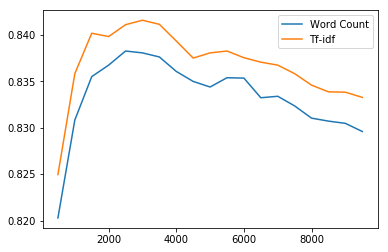

In [38]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(possible_n, cnt_accuracies, label='Word Count')
plt.plot(possible_n, tfidf_accuracies, label='Tf-idf')
plt.legend()

## Save model

In [39]:
best = train_with_n_topwords(3000, tfidf=True)

In [40]:
best

(0.8416,
 MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True),
 TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
         dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
         lowercase=True, max_df=1.0, max_features=None, min_df=1,
         ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
         stop_words=None, strip_accents=None, sublinear_tf=False,
         token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
         vocabulary=['film', 'movie', 'one', 'make', 'like', 'see', 'get', 'time', 'good', 'character', 'go', 'watch', 'even', 'would', 'think', 'story', 'really', 'well', 'show', 'look', 'much', 'say', 'end', 'know', 'people', 'bad', 'also', 'first', 'great', 'give', 'act', 'take', 'play', 'love', 'come', '...ncreasingly', 'le', 'cox', 'sketch', 'vary', 'korean', 'mafia', 'carrey', 'cardboard', 'university']))

In [41]:
import pickle

# Save vectorizer
with open('tf_vec1211.pkl', 'wb') as pkl_file:
    pickle.dump(best[2], pkl_file)

In [42]:
with open('mnb_model1211.pkl', 'wb') as pkl_file:
    pickle.dump(best[1], pkl_file)